<a href="https://colab.research.google.com/github/carolinampessoa/TechChallengeFase2/blob/main/TechChallengeFase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1) Definindo o problema**

Escolha um problema real que possa ser resolvido por meio de otimização genética. Descreva o problema, os objetivos e os critérios de sucesso.

##**2) Implementação do AG**

In [ ]:
# Importação de bibliotecas
import random
import matplotlib.pyplot as plt

# Configurações iniciais do problema
NUM_TAREFAS = 10000
NUM_MAQUINAS = 20
TAMANHO_POPULACAO = 50
GERACOES = 100
TAXA_CROSSOVER = 0.8
TAXA_MUTACAO = 0.1

In [ ]:
# CRIAR UM INDIVÍDUO (alocação de tarefas em máquinas)
def criar_individuo():
    return [random.randint(0, NUM_MAQUINAS - 1) for _ in range(NUM_TAREFAS)]

# FITNESS = makespan (menor é melhor)
def avaliar(individuo):
    maquinas = [0] * NUM_MAQUINAS
    for i, m in enumerate(individuo):
        maquinas[m] += tarefas[i]
    return max(maquinas)  # tempo da máquina mais carregada

# SELEÇÃO POR TORNEIO
def selecao(populacao):
    a, b = random.sample(populacao, 2)
    return a if avaliar(a) < avaliar(b) else b

# CRUZAMENTO (crossover de um ponto)
def crossover(pai1, pai2):
    if random.random() < TAXA_CROSSOVER:
        ponto = random.randint(1, NUM_TAREFAS - 1)
        return pai1[:ponto] + pai2[ponto:]
    return pai1[:]

# MUTAÇÃO (muda a máquina de uma tarefa aleatória)
def mutacao(individuo):
    if random.random() < TAXA_MUTACAO:
        idx = random.randint(0, NUM_TAREFAS - 1)
        individuo[idx] = random.randint(0, NUM_MAQUINAS - 1)
    return individuo

# ALGORITMO GENÉTICO PRINCIPAL
def algoritmo_genetico():
    populacao = [criar_individuo() for _ in range(TAMANHO_POPULACAO)]
    melhor = min(populacao, key=avaliar)

    for geracao in range(GERACOES):
        nova_pop = []
        for _ in range(TAMANHO_POPULACAO):
            p1 = selecao(populacao)
            p2 = selecao(populacao)
            filho = crossover(p1, p2)
            filho = mutacao(filho)
            nova_pop.append(filho)

        populacao = nova_pop
        melhor_atual = min(populacao, key=avaliar)
        if avaliar(melhor_atual) < avaliar(melhor):
            melhor = melhor_atual
        print(f"Geração {geracao+1}: Melhor makespan = {avaliar(melhor)}")

    return melhor

In [ ]:
# GERAÇÃO DAS TAREFAS (durações aleatórias entre 1 e 20)
tarefas = [random.randint(1, 20) for _ in range(NUM_TAREFAS)]

In [ ]:
# EXECUTAR
melhor_solucao = algoritmo_genetico()
print("\nTarefas:", tarefas)
print("Melhor solução:", melhor_solucao)
print("Makespan:", avaliar(melhor_solucao))

Geração 1: Melhor makespan = 643
Geração 2: Melhor makespan = 636
Geração 3: Melhor makespan = 624
Geração 4: Melhor makespan = 614
Geração 5: Melhor makespan = 614
Geração 6: Melhor makespan = 614
Geração 7: Melhor makespan = 610
Geração 8: Melhor makespan = 602
Geração 9: Melhor makespan = 602
Geração 10: Melhor makespan = 593
Geração 11: Melhor makespan = 589
Geração 12: Melhor makespan = 585
Geração 13: Melhor makespan = 585
Geração 14: Melhor makespan = 585
Geração 15: Melhor makespan = 585
Geração 16: Melhor makespan = 585
Geração 17: Melhor makespan = 585
Geração 18: Melhor makespan = 584
Geração 19: Melhor makespan = 584
Geração 20: Melhor makespan = 584
Geração 21: Melhor makespan = 584
Geração 22: Melhor makespan = 581
Geração 23: Melhor makespan = 581
Geração 24: Melhor makespan = 580
Geração 25: Melhor makespan = 580
Geração 26: Melhor makespan = 580
Geração 27: Melhor makespan = 580
Geração 28: Melhor makespan = 577
Geração 29: Melhor makespan = 577
Geração 30: Melhor make


--- AG Clássico - sem crossover e sem mutação ---
Geração   1: Melhor fitness = 608
Geração   2: Melhor fitness = 608
Geração   3: Melhor fitness = 608
Geração   4: Melhor fitness = 608
Geração   5: Melhor fitness = 608
Geração   6: Melhor fitness = 608
Geração   7: Melhor fitness = 608
Geração   8: Melhor fitness = 608
Geração   9: Melhor fitness = 608
Geração  10: Melhor fitness = 608
Geração  11: Melhor fitness = 608
Geração  12: Melhor fitness = 608
Geração  13: Melhor fitness = 608
Geração  14: Melhor fitness = 608
Geração  15: Melhor fitness = 608
Geração  16: Melhor fitness = 608
Geração  17: Melhor fitness = 608
Geração  18: Melhor fitness = 608
Geração  19: Melhor fitness = 608
Geração  20: Melhor fitness = 608
Geração  21: Melhor fitness = 608
Geração  22: Melhor fitness = 608
Geração  23: Melhor fitness = 608
Geração  24: Melhor fitness = 608
Geração  25: Melhor fitness = 608
Geração  26: Melhor fitness = 608
Geração  27: Melhor fitness = 608
Geração  28: Melhor fitness = 6

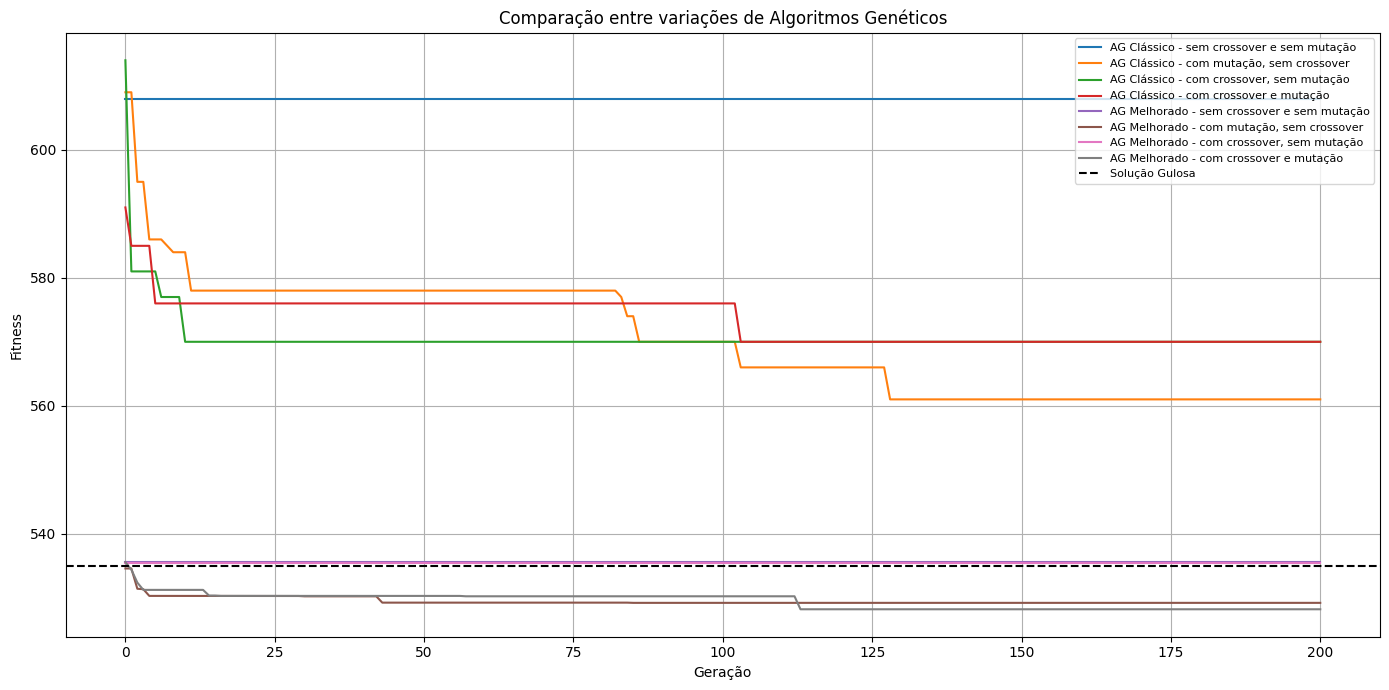

In [ ]:
import random
import matplotlib.pyplot as plt

# CONFIGURAÇÕES
NUM_TAREFAS = 1000
NUM_MAQUINAS = 20
TAMANHO_POPULACAO = 100
GERACOES = 200
TAXA_CROSSOVER = 0.8
TAXA_MUTACAO = 0.1

# TAREFAS ALEATÓRIAS
tarefas = [random.randint(1, 20) for _ in range(NUM_TAREFAS)]

# AVALIAÇÃO CLÁSSICA (somente makespan)
def avaliar_clássico(individuo):
    maquinas = [0] * NUM_MAQUINAS
    for i, m in enumerate(individuo):
        maquinas[m] += tarefas[i]
    return max(maquinas)

# AVALIAÇÃO MELHORADA (makespan + desbalanceamento)
def avaliar_melhorado(individuo):
    maquinas = [0] * NUM_MAQUINAS
    for i, m in enumerate(individuo):
        maquinas[m] += tarefas[i]
    makespan = max(maquinas)
    media = sum(maquinas) / NUM_MAQUINAS
    desvio = sum(abs(x - media) for x in maquinas) / NUM_MAQUINAS
    return makespan + 0.1 * desvio

# CRIAÇÃO DE INDIVÍDUO
def criar_individuo():
    return [random.randint(0, NUM_MAQUINAS - 1) for _ in range(NUM_TAREFAS)]

# SOLUÇÃO GULOSA PARA INJETAR OU COMPARAR
def solucao_gulosa():
    maquinas = [0] * NUM_MAQUINAS
    individuo = []
    for t in tarefas:
        idx = maquinas.index(min(maquinas))
        maquinas[idx] += t
        individuo.append(idx)
    return individuo

# POPULAÇÃO INICIAL (com ou sem injeção gulosa)
def criar_populacao(usar_injecao_gulosa):
    pop = [criar_individuo() for _ in range(TAMANHO_POPULACAO - 5)] if usar_injecao_gulosa else [criar_individuo() for _ in range(TAMANHO_POPULACAO)]
    if usar_injecao_gulosa:
        base = solucao_gulosa()
        for _ in range(5):
            mutado = aplicar_mutacao(base[:], usar_mutacao=True, guiada=True)
            pop.append(mutado)
    return pop

# SELEÇÃO
def selecao(populacao, func_avaliar):
    a, b = random.sample(populacao, 2)
    return a if func_avaliar(a) < func_avaliar(b) else b

# CROSSOVER DE DOIS PONTOS
def aplicar_crossover(pai1, pai2, usar_crossover):
    if usar_crossover and random.random() < TAXA_CROSSOVER:
        p1, p2 = sorted(random.sample(range(NUM_TAREFAS), 2))
        return pai1[:p1] + pai2[p1:p2] + pai1[p2:]
    return pai1[:]

# MUTAÇÃO GUIADA
def aplicar_mutacao(individuo, usar_mutacao=True, guiada=False):
    if not usar_mutacao:
        return individuo
    num_mutacoes = int(NUM_TAREFAS * TAXA_MUTACAO)
    for _ in range(num_mutacoes):
        idx = random.randint(0, NUM_TAREFAS - 1)
        if guiada:
            cargas = [0] * NUM_MAQUINAS
            for i, m in enumerate(individuo):
                cargas[m] += tarefas[i]
            melhor_maquina = cargas.index(min(cargas))
            individuo[idx] = melhor_maquina
        else:
            individuo[idx] = random.randint(0, NUM_MAQUINAS - 1)
    return individuo

# EXECUÇÃO DO AG COM CONFIGURAÇÕES DINÂMICAS
def executar_ag(nome_execucao, usar_crossover, usar_mutacao, melhorado=False):
    print(f"\n--- {nome_execucao} ---")
    usar_injecao_gulosa = melhorado
    func_avaliar = avaliar_melhorado if melhorado else avaliar_clássico
    populacao = criar_populacao(usar_injecao_gulosa)
    melhor = min(populacao, key=func_avaliar)
    historico = [func_avaliar(melhor)]

    for geracao in range(GERACOES):
        nova_pop = [melhor]  # elitismo
        while len(nova_pop) < TAMANHO_POPULACAO:
            p1 = selecao(populacao, func_avaliar)
            p2 = selecao(populacao, func_avaliar)
            filho = aplicar_crossover(p1, p2, usar_crossover)
            filho = aplicar_mutacao(filho, usar_mutacao, guiada=melhorado)
            nova_pop.append(filho)

        populacao = nova_pop
        melhor_atual = min(populacao, key=func_avaliar)
        if func_avaliar(melhor_atual) < func_avaliar(melhor):
            melhor = melhor_atual

        historico.append(func_avaliar(melhor))
        print(f"Geração {geracao+1:3}: Melhor fitness = {func_avaliar(melhor)}")

    return melhor, historico, func_avaliar(melhor)

# VARIAÇÕES (nome, crossover, mutação, versão melhorada)
versoes = [
    ("AG Clássico - sem crossover e sem mutação", False, False, False),
    ("AG Clássico - com mutação, sem crossover", False, True, False),
    ("AG Clássico - com crossover, sem mutação", True, False, False),
    ("AG Clássico - com crossover e mutação", True, True, False),
    ("AG Melhorado - sem crossover e sem mutação", False, False, True),
    ("AG Melhorado - com mutação, sem crossover", False, True, True),
    ("AG Melhorado - com crossover, sem mutação", True, False, True),
    ("AG Melhorado - com crossover e mutação", True, True, True),
]

resultados = {}
for nome, cross, mut, melhorado in versoes:
    melhor, hist, fitness = executar_ag(nome, cross, mut, melhorado)
    resultados[nome] = {
        "historico": hist,
        "fitness": fitness,
    }

# Solução Gulosa
sol_gulosa = solucao_gulosa()
fitness_gulosa = avaliar_clássico(sol_gulosa)




## **3) Testes e Resultados**

In [ ]:
print("\n==================== RESULTADOS FINAIS ====================")
for nome, dados in resultados.items():
    print(f"{nome:50} -> Fitness final: {dados['fitness']:.2f}")
print(f"{'Solução Gulosa':50} -> Fitness final: {fitness_gulosa:.2f}")
print("===========================================================")

# GRÁFICO COMPARATIVO
plt.figure(figsize=(14, 7))
for nome, dados in resultados.items():
    plt.plot(dados["historico"], label=nome)
plt.axhline(y=fitness_gulosa, color='black', linestyle='--', label="Solução Gulosa")
plt.xlabel("Geração")
plt.ylabel("Fitness")
plt.title("Comparação entre variações de Algoritmos Genéticos")
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()